Train HOG Classifier
===


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lesson_functions import *
from sklearn.utils import shuffle

### Load cars and notcars data sets

In [2]:
from train_hog_classifier import load_data_sets
cars, notcars = load_data_sets()

### Two classes are quite balanced

In [3]:
print('Number of samples in cars set: ', len(cars))
print('Number of samples in notcars set: ', len(notcars))

Number of samples in cars set:  8792
Number of samples in notcars set:  8968


### Extract features from image files 

In [4]:
from train_hog_classifier import extract_features

params = {}

params['color_space'] = 'LUV'#YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
params['orient'] = 9  # HOG orientations
params['pix_per_cell'] = 8 # HOG pixels per cell
params['cell_per_block'] = 2 # HOG cells per block
params['hog_channel'] = 'ALL' # Can be 0, 1, 2, or "ALL"
params['spatial_size'] = (32, 32) # Spatial binning dimensions
params['hist_bins'] = 32    # Number of histogram bins
params['spatial_feat'] = True # Spatial features on or off
params['hist_feat'] = True # Histogram features on or off
params['hog_feat'] = True # HOG features on or off

t1=time.time()

cars_feats = extract_features(cars, params)
notcars_feats = extract_features(notcars, params)

t2 = time.time()
print(round(t2-t1, 2), 'second to extract features (HOG,spatial and color features).')

93.13 second to extract features (HOG,spatial and color features).


In [9]:
assert(len(cars_feats) == len(cars))
assert(len(notcars_feats) == len(notcars))

### Combine and Normalize Features

In [6]:
# Create an array stack of feature vectors
X = np.vstack((cars_feats, notcars_feats)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

### Split up data into randomized training and test sets

In [7]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Number of samples in train set: ', len(X_train))
print('Number of samples in test set: ', len(X_test))

Number of samples in train set:  14208
Number of samples in test set:  3552


### Save prepared train and test sets to pickle file

In [9]:
from train_hog_classifier import save_classifier_data
#save_classifier_data('HOGClassifierData.p', X_train, y_train, X_test, y_test)

Saving features/labels to pickle file...
Classifier data cached in pickle file.


### Train SVM Classifier

In [ ]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 100
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8460


### Save HOG Classifier to file

In [10]:
from train_hog_classifier import save_classifier
save_classifier('HOGClassifier.p', svc, X_scaler, params)

Saving classiifier to pickle file...
Classifier saved in pickle file.


### Test prediction

0.35824 Seconds to detect using scale: 1.3


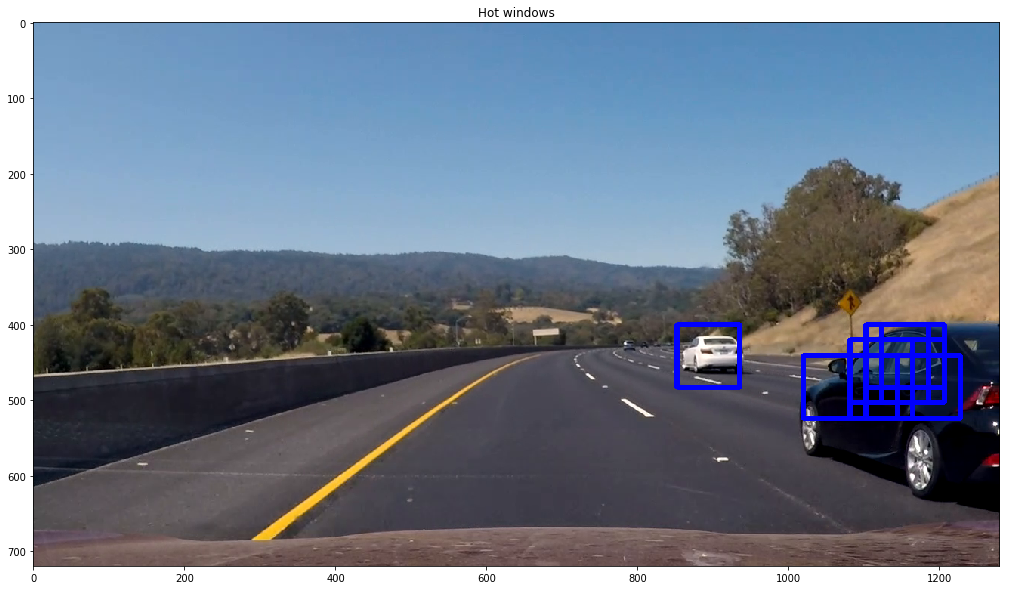

In [12]:
from find_cars import find_cars
%matplotlib inline

dist_pickle = pickle.load( open("HOGClassifier.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

params = {}
params['color_space']    = dist_pickle['color_space']
params['orient']         = dist_pickle['orient']
params['pix_per_cell']   = dist_pickle['pix_per_cell']
params['cell_per_block'] = dist_pickle['cell_per_block']
params['hog_channel']    = dist_pickle['hog_channel']
params['spatial_size']   = dist_pickle['spatial_size']
params['hist_bins']      = dist_pickle['hist_bins']
params['spatial_feat']   = dist_pickle['spatial_feat']
params['hist_feat']      = dist_pickle['hist_feat']
params['hog_feat']       = dist_pickle['hog_feat']

#print('color_space: ', params['color_space'])
#print('orient: ', params['orient'])
#print('pix_per_cell: ', params['pix_per_cell'])
#print('cell_per_block: ', params['cell_per_block'])
#print('hog_channel: ', params['hog_channel'])
#print('spatial_size: ', params['spatial_size'])
#print('hist_bins: ', params['hist_bins'])
#print('spatial_feat: ', params['spatial_feat'])
#print('hist_feat: ', params['hist_feat'])
#print('hog_feat: ', params['hog_feat'])

#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
#img = mpimg.imread('test_images/test6.jpg')

img = mpimg.imread('temp_data/frames/project_video/718.jpg')

if img.shape[2] > 3:
    img = img[:,:,0:3]


ystart = 400
ystop = 656
scale = 1.3
    
draw_img = np.copy(img)
img = img.astype(np.float32)/255

t=time.time()

bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, params)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to detect using scale:', scale)

draw_img = draw_boxes(draw_img, bboxes)

fig = plt.figure(figsize=(20,10))
plt.imshow(draw_img)
plt.title('Hot windows')
plt.show()
